# RAF-DB

## Part 1: train local net, global net, concat global và local

### Data

In [10]:
!pip install huggingface_hub


In [11]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="DaoHuyen/XLA",
    repo_type="model",
    local_dir="data_downloaded"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

weights/The_best_weights_raf_new.weights(…):   0%|          | 0.00/135M [00:00<?, ?B/s]

weights/RAF_best_model.weights.h5:   0%|          | 0.00/101M [00:00<?, ?B/s]

data/rafdb_dataset_3.npz:   0%|          | 0.00/2.03G [00:00<?, ?B/s]

data/ck2.npz:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

data/ck.npz:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

'/content/data_downloaded'

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
import h5py

# Load
data = np.load("/content/data_downloaded/data/rafdb_dataset_3.npz")

x_train = data["x_train"]
y_train = data["y_train"]
x_test  = data["x_test"]
y_test  = data["y_test"]


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [ ]:
# Số lượng mẫu
print("Train samples:", len(x_train))
print("Validation samples:", len(x_val))
print("Test samples:", len(x_test))

# Shape của ảnh
print("Train images shape:", x_train.shape)
print("Validation images shape:", x_val.shape)
print("Test images shape:", x_test.shape)

# Kiểm tra nhãn
print("Train labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

# Các nhãn duy nhất trong tập train/test
print("Unique labels in train:", np.unique(y_train))
print("Unique labels in validation:", np.unique(y_val))
print("Unique labels in test:", np.unique(y_test))



Train samples: 9816
Validation samples: 2455
Test samples: 3068
Train images shape: (9816, 224, 224, 3)
Validation images shape: (2455, 224, 224, 3)
Test images shape: (3068, 224, 224, 3)
Train labels shape: (9816,)
Validation labels shape: (2455,)
Test labels shape: (3068,)
Unique labels in train: [0 1 2 3 4 5 6]
Unique labels in validation: [0 1 2 3 4 5 6]
Unique labels in test: [0 1 2 3 4 5 6]


In [ ]:
num_classes = 7
y_train = to_categorical(y_train, num_classes)
y_val   = to_categorical(y_val, num_classes)
y_test  = to_categorical(y_test, num_classes)


### Multi with weight share

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, AveragePooling2D, Activation, Dense, PReLU, Layer
from tensorflow.keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Concatenate, Cropping2D, Multiply, Lambda, Flatten, Reshape
from tensorflow.keras.activations import relu, softmax, sigmoid, tanh
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import tensorflow.keras.backend as K

class Patches(Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, inputs, **kwargs):
        patch = tf.concat((tf.split(inputs,num_or_size_splits=7,axis=1)), axis=-1)
        patch = tf.concat((tf.split(patch, num_or_size_splits=7, axis=2)), axis=-1)
        return patch

    def get_config(self):
        config = {'patch_size':self.patch_size}
        base_config = super(Patches, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def Global_Net(input, eps):
    x_g_1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(1, 1), padding='same', activation=relu)(input)
    x_g_1 = BatchNormalization(axis=-1, epsilon=eps)(x_g_1)
    x_g_1 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x_g_1)
    x_g_1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_g_1)
    x_g_1 = BatchNormalization(axis=-1, epsilon=eps)(x_g_1)
    x_g_1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_g_1)

    x_g_2 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_g_1)
    x_g_2 = BatchNormalization(axis=-1, epsilon=eps)(x_g_2)
    x_g_2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_g_2)

    x_g_3 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_g_2)
    x_g_3 = BatchNormalization(axis=-1, epsilon=eps)(x_g_3)
    x_g_3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_g_3)

    x_g_4 = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_g_3)
    x_g_4 = BatchNormalization(axis=-1, epsilon=eps)(x_g_4)
    x_g_4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_g_4)

    return x_g_4

def Local_Net(input, eps):
    x_l_1 = Conv2D(filters=128, kernel_size=(7, 7), strides=(1, 1), padding='same', activation=relu)(input)
    x_l_1 = BatchNormalization(axis=-1, epsilon=eps)(x_l_1)
    x_l_1 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x_l_1)
    x_l_1 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_l_1)
    x_l_1 = BatchNormalization(axis=-1, epsilon=eps)(x_l_1)
    x_l_1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_l_1)

    x_l_2 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_l_1)
    x_l_2 = BatchNormalization(axis=-1, epsilon=eps)(x_l_2)
    x_l_2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_l_2)

    x_l_3 = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_l_2)
    x_l_3 = BatchNormalization(axis=-1, epsilon=eps)(x_l_3)
    x_l_3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_l_3)

    x_l_4 = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu)(x_l_3)
    x_l_4 = BatchNormalization(axis=-1, epsilon=eps)(x_l_4)
    x_l_4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x_l_4)

    return x_l_4

def Enhance_Net(eps = 1.1e-5):

    input = Input(shape=(224, 224, 3))

    x_l_0 = Patches(patch_size=32)(input)
    x_g_0 = input

    x_l = Local_Net(x_l_0, eps)
    x_g = Global_Net(x_g_0, eps)

    x_l = GlobalAveragePooling2D()(x_l)
    x_g = GlobalAveragePooling2D()(x_g)

    x_c = Concatenate()([x_l, x_g])

    x_l = Dense(units=1024, activation=relu)(x_l)
    x_g = Dense(units=1024, activation=relu)(x_g)

    share_1 = Dense(units=2048, activation=relu)
    share_2 = Dense(units=2048, activation=relu)
    share_3 = Dense(units=7, activation=softmax)

    x_l = share_1(x_l)
    x_g = share_1(x_g)
    x_c = share_1(x_c)

    x_l = share_2(x_l)
    x_g = share_2(x_g)
    x_c = share_2(x_c)

    out_l = share_3(x_l)
    out_g = share_3(x_g)
    out_c = share_3(x_c)

    model = Model(input, [out_l, out_g, out_c])

    return model

model = Enhance_Net()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, 32, 32,    │          0 │ input_layer[0][0] │
│                     │ 147)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │    922,112 │ patches[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    147,584 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]  

 Total params: 13,871,175 (52.91 MB)

 Trainable params: 13,866,055 (52.89 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model, Model
import h5py
import os

# ---- GPU settings trên Colab TF2 ----
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)



opt = tf.keras.optimizers.Nadam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss=[
        'categorical_crossentropy',
        'categorical_crossentropy',
        'categorical_crossentropy'
    ],
    metrics=[
        ['accuracy'],
        ['accuracy'],
        ['accuracy']
    ]
)


file_path = './The_best_weights_raf_new.weights.h5'


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.1,
    patience=50,
    min_delta=0.001,
    cooldown=0,
    min_lr=1e-8
)

checkpoint = ModelCheckpoint(
    filepath=file_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# ---- Train model ----
print('########## fit processing ##########')
model.fit(
    x=x_train,
    y=[y_train, y_train, y_train],
    batch_size=32,
    epochs=40,
    verbose=1,
    shuffle=True,
    callbacks=[checkpoint, reduce_lr],
    validation_data=(x_val, [y_val, y_val, y_val])
)




Physical devices cannot be modified after being initialized
########## fit processing ##########
Epoch 1/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - dense_4_accuracy: 0.4684 - dense_4_accuracy_1: 0.3910 - dense_4_accuracy_2: 0.4703 - dense_4_loss: 1.4934 - loss: 4.5599
Epoch 1: val_loss improved from inf to 4.88610, saving model to ./The_best_weights_raf_new.weights.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 143s 353ms/step - dense_4_accuracy: 0.4686 - dense_4_accuracy_1: 0.3910 - dense_4_accuracy_2: 0.4705 - dense_4_loss: 1.4929 - loss: 4.5589 - val_dense_4_accuracy: 0.5055 - val_dense_4_accuracy_1: 0.3914 - val_dense_4_accuracy_2: 0.4998 - val_dense_4_loss: 1.6544 - val_loss: 4.8861 - learning_rate: 1.0000e-04
Epoch 2/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - dense_4_accuracy: 0.5837 - dense_4_accuracy_1: 0.4494 - dense_4_accuracy_2: 0.5904 - dense_4_loss: 1.1386 - loss: 3.7778
Epoch 2: val_loss improved from 4.88610 to 4.46096, saving model to ./The_best_weights_raf_new.weights.h5
30

KeyboardInterrupt: 

In [ ]:
# ---- Predict ----
print('########## predict processing ##########')
# Chỉ load weights vì model đã được define sẵn
model.load_weights(filepath=file_path)

y_pred = model.predict(x_test, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred[0], axis=1)  # Lưu ý: output là list
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true=y_true, y_pred=y_pred))



########## predict processing ##########
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step
Accuracy: 0.6597131681877445


In [ ]:
from huggingface_hub import login
from huggingface_hub import upload_file
from google.colab import userdata

token_hug = userdata.get('token_hugging')

login(token=token_hug)

upload_file(
    path_or_fileobj="/content/The_best_weights_raf_new.weights.h5",   # file local
    path_in_repo="weights/65_The_best_weights_raf_new.weights.h5",                    # tên file khi upload lên repo
    repo_id="DaoHuyen/XLA",                      # repo đích
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...eights_raf_new.weights.h5:   0%|          |  568kB /  167MB            

CommitInfo(commit_url='https://huggingface.co/DaoHuyen/XLA/commit/adb9d7b37ea5d9eed4fc19790fa13970e50714b2', commit_message='Upload weights/65_The_best_weights_raf_new.weights.h5 with huggingface_hub', commit_description='', oid='adb9d7b37ea5d9eed4fc19790fa13970e50714b2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/DaoHuyen/XLA', endpoint='https://huggingface.co', repo_type='model', repo_id='DaoHuyen/XLA'), pr_revision=None, pr_num=None)

## Part 2: constrain fusion

### Input for model contrain fusion

In [ ]:
# ---- Extract intermediate outputs ----
model_pred = Model(
    inputs=model.input,
    outputs=[model.get_layer('dense').output,
             model.get_layer('dense_1').output,
             model.get_layer('concatenate').output]
)

# Train features
x_l_tr_raf, x_g_tr_raf, x_c_tr_raf = model_pred.predict(x_train, batch_size=32, verbose=1)

# Val features  ← THÊM PHẦN NÀY
x_l_val_raf, x_g_val_raf, x_c_val_raf = model_pred.predict(x_val, batch_size=32, verbose=1)

# Test features
x_l_te_raf, x_g_te_raf, x_c_te_raf = model_pred.predict(x_test, batch_size=32, verbose=1)


with h5py.File('./raf_sample_label.h5', 'w') as f:
    # Train
    f.create_dataset('x_l_tr_raf', data=x_l_tr_raf)
    f.create_dataset('x_g_tr_raf', data=x_g_tr_raf)
    f.create_dataset('x_c_tr_raf', data=x_c_tr_raf)

    # Validation  ← THÊM
    f.create_dataset('x_l_val_raf', data=x_l_val_raf)
    f.create_dataset('x_g_val_raf', data=x_g_val_raf)
    f.create_dataset('x_c_val_raf', data=x_c_val_raf)

    # Test
    f.create_dataset('x_l_te_raf', data=x_l_te_raf)
    f.create_dataset('x_g_te_raf', data=x_g_te_raf)
    f.create_dataset('x_c_te_raf', data=x_c_te_raf)

    # Labels
    f.create_dataset('label_tr', data=y_train)
    f.create_dataset('label_val', data=y_val)   # ← THÊM
    f.create_dataset('label_te', data=y_test)


307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step


### Model

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Multiply, Add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax

def Cosin_similarity(input):
    dot1 = K.batch_dot(input[0], input[1], axes=1)
    dot2 = K.batch_dot(input[0], input[0], axes=1)
    dot3 = K.batch_dot(input[1], input[1], axes=1)
    max = K.maximum(K.sqrt(dot2 * dot3), K.epsilon())
    value = dot1 / max
    return K.tanh(value)

def Bund(input):
    alpha_1 = input[0]
    alpha_2 = input[1]

    alpha_l = alpha_1/(alpha_1+alpha_2)
    alpha_g = alpha_2/(alpha_1+alpha_2)

    return alpha_l, alpha_g

def Fusion_Net():
    input_1 = Input(shape=(1024, ))
    input_2 = Input(shape=(1024, ))
    input_3 = Input(shape=(1024, ))

    x_l = Dense(units=2048, activation=relu)(input_1)
    x_g = Dense(units=2048, activation=relu)(input_2)
    x_c = Dense(units=2048, activation=relu)(input_3)

    alpha_1 = Lambda(Cosin_similarity)([x_l, x_c])
    alpha_2 = Lambda(Cosin_similarity)([x_g, x_c])
    alpha_l, alpha_g = Lambda(Bund)([alpha_1, alpha_2])
    out_l = Multiply()([alpha_l, x_l])
    out_g = Multiply()([alpha_g, x_g])

    out = Concatenate()([out_l, out_g])

    out = Dense(units=7, activation=softmax)(out)

    model = Model([input_1, input_2, input_3], out)

    return model

### train

In [ ]:
import h5py
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow import keras
from sklearn.metrics import balanced_accuracy_score


if __name__ == '__main__':
    with h5py.File('./raf_sample_label.h5', 'r') as f:
      x_l_tr_raf = f['x_l_tr_raf'][:]
      x_g_tr_raf = f['x_g_tr_raf'][:]
      x_c_tr_raf = f['x_c_tr_raf'][:]

      x_l_val_raf = f['x_l_val_raf'][:]     # NEW
      x_g_val_raf = f['x_g_val_raf'][:]     # NEW
      x_c_val_raf = f['x_c_val_raf'][:]     # NEW

      x_l_te_raf = f['x_l_te_raf'][:]
      x_g_te_raf = f['x_g_te_raf'][:]
      x_c_te_raf = f['x_c_te_raf'][:]

      label_tr = f['label_tr'][:]
      label_val = f['label_val'][:]         # NEW
      label_te = f['label_te'][:]


    print(x_l_tr_raf.shape, x_g_tr_raf.shape, x_c_tr_raf.shape)


    model = Fusion_Net()
    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['acc']
    )


    file_path = './RAF_best_model.weights.h5'

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                  verbose=1,
                                                  mode='auto',
                                                  factor=0.1,
                                                  min_delta=0.001,
                                                  patience=50,
                                                  cooldown=0,
                                                  min_lr=0.00000001)

    checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                 monitor='val_acc',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1,
                                                 save_weights_only=True
                                                 )

    model.fit(x=[x_l_tr_raf, x_g_tr_raf, x_c_tr_raf], y=label_tr,
              batch_size=32,
              epochs=2000,
              verbose=1,
              callbacks=[checkpoint, reduce_lr],
              validation_data=(
                  [x_l_val_raf, x_g_val_raf, x_c_val_raf],
                  label_val
              ))

    model = load_model(filepath=file_path, compile=False)

    y_pred = model.predict([x_l_te_raf, x_g_te_raf, x_c_te_raf], batch_size=32)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(label_te, axis=1)


    print(balanced_accuracy_score(y_true=y_true, y_pred=y_pred))

(9816, 1024) (9816, 1024) (9816, 1024)
Epoch 1/2000
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.7189 - loss: 0.8160
Epoch 1: val_acc improved from -inf to 0.69409, saving model to ./RAF_best_model.weights.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.7191 - loss: 0.8153 - val_acc: 0.6941 - val_loss: 0.9582 - learning_rate: 1.0000e-04
Epoch 2/2000
290/307 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8666 - loss: 0.3898
Epoch 2: val_acc improved from 0.69409 to 0.71079, saving model to ./RAF_best_model.weights.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8668 - loss: 0.3892 - val_acc: 0.7108 - val_loss: 0.9149 - learning_rate: 1.0000e-04
Epoch 3/2000
290/307 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9045 - loss: 0.2940
Epoch 3: val_acc improved from 0.71079 to 0.72587, saving model to ./RAF_best_model.weights.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9048 - loss: 0.2931 - val_acc: 0.7259 - val_loss: 0.8855 - learning_rate: 1.0000e-04
Epoch 4/2000
296/307 ━━

KeyboardInterrupt: 

In [ ]:
from huggingface_hub import login
from huggingface_hub import upload_file

login(token=token_hug)

upload_file(
    path_or_fileobj="/content/RAF_best_model.weights.h5",   # file local
    path_in_repo="weights/65_74_RAF_best_model.weights.h5",                    # tên file khi upload lên repo
    repo_id="DaoHuyen/XLA",                      # repo đích
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...RAF_best_model.weights.h5:   1%|          |  542kB / 76.0MB            

CommitInfo(commit_url='https://huggingface.co/DaoHuyen/XLA/commit/2ac9298e4e86476c546ea2bc9f1c6ef583e3c757', commit_message='Upload weights/65_74_RAF_best_model.weights.h5 with huggingface_hub', commit_description='', oid='2ac9298e4e86476c546ea2bc9f1c6ef583e3c757', pr_url=None, repo_url=RepoUrl('https://huggingface.co/DaoHuyen/XLA', endpoint='https://huggingface.co', repo_type='model', repo_id='DaoHuyen/XLA'), pr_revision=None, pr_num=None)

### bench mark

In [14]:
# ---- Extract intermediate outputs ----
model_pred = Model(
    inputs=model.input,
    outputs=[model.get_layer('dense_5').output,
             model.get_layer('dense_6').output,
             model.get_layer('concatenate_1').output]
)

# Test features
x_l_te_raf, x_g_te_raf, x_c_te_raf = model_pred.predict(x_test, batch_size=32, verbose=1)


with h5py.File('./raf_sample_label.h5', 'w') as f:

    # Test
    f.create_dataset('x_l_te_raf', data=x_l_te_raf)
    f.create_dataset('x_g_te_raf', data=x_g_te_raf)
    f.create_dataset('x_c_te_raf', data=x_c_te_raf)

    # Labels
    f.create_dataset('label_te', data=y_test)


96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step


In [15]:
y_pred = fusion_model.predict([x_l_te_raf, x_g_te_raf, x_c_te_raf], batch_size=32)


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [16]:
import numpy as np

y_pred_label = np.argmax(y_pred, axis=1)


In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(y_test, y_pred_label)
print("Accuracy:", acc)

print("Classification report:")
print(classification_report(y_test, y_pred_label))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_label))


Accuracy: 0.7395697522816167
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       329
           1       0.52      0.41      0.45        74
           2       0.43      0.38      0.40       160
           3       0.84      0.87      0.86      1185
           4       0.69      0.61      0.65       478
           5       0.57      0.64      0.60       162
           6       0.69      0.73      0.71       680

    accuracy                           0.74      3068
   macro avg       0.65      0.63      0.64      3068
weighted avg       0.74      0.74      0.74      3068

Confusion matrix:
[[ 254    7    2   13    9   11   33]
 [  13   30    0    9    6   10    6]
 [   5    5   61   21   14   14   40]
 [  16    5   24 1034   36   11   59]
 [   4    6   17   62  291   25   73]
 [   7    4    9   19    8  104   11]
 [  20    1   29   67   60    8  495]]


## Inference

In [1]:
! unzip -q /content/test.zip -d /content/test

In [2]:
from huggingface_hub import hf_hub_download
from google.colab import userdata

token_hug = userdata.get('token_hugging')
# Tải file về
weight_path_multi = hf_hub_download(
    repo_id="DaoHuyen/XLA",                           # repo của bạn
    filename="weights/65_The_best_weights_raf_new.weights.h5",  # đường dẫn file trong repo
    token=token_hug    # token nếu repo private
)

weight_path_constrain = hf_hub_download(
    repo_id="DaoHuyen/XLA",
    filename="weights/65_74_RAF_best_model.weights.h5",
    token=token_hug
)

print("weight_path_multi đã được tải về:", weight_path_multi)
print("weight_path_constrain đã được tải về:", weight_path_constrain)


weights/65_The_best_weights_raf_new.weig(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

weights/65_74_RAF_best_model.weights.h5:   0%|          | 0.00/76.0M [00:00<?, ?B/s]

weight_path_multi đã được tải về: /root/.cache/huggingface/hub/models--DaoHuyen--XLA/snapshots/56ed02b63ed067eba8298bac6e37d73505a741d3/weights/65_The_best_weights_raf_new.weights.h5
weight_path_constrain đã được tải về: /root/.cache/huggingface/hub/models--DaoHuyen--XLA/snapshots/56ed02b63ed067eba8298bac6e37d73505a741d3/weights/65_74_RAF_best_model.weights.h5


In [5]:
# Tạo model extract feature
from tensorflow.keras.models import Model
model = Enhance_Net()
model.summary()
model.load_weights(weight_path_multi)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, 32, 32,    │          0 │ input_layer_1[0]… │
│                     │ 147)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    922,112 │ patches_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    147,584 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │     36,928 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_12[0][0] 

 Total params: 13,871,175 (52.91 MB)

 Trainable params: 13,866,055 (52.89 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [6]:
feature_model = Model(
    inputs=model.input,
    outputs=[model.get_layer('dense_5').output,  # x_l Dense(1024)
             model.get_layer('dense_6').output,  # x_g Dense(1024)
             model.get_layer('concatenate_1').output]  # x_c Dense(1024)
)


In [7]:
classes = [{0: "Surprise"}, {1:"Fear"}, {2:"Disgust"}, {3:"Happy"}, {4:"Sad"}, {5:"Angry"}, {6:"Neutral"}]

In [8]:
fusion_model = Fusion_Net()
fusion_model.load_weights(weight_path_constrain)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Ảnh: neutral.jpg
→ Output: [[2.2382878e-06 2.4034279e-18 2.2743393e-18 2.0018476e-15 1.4449751e-32
  3.3795805e-16 9.9999774e-01]]
→ Dự đoán: {6: 'Neutral'}


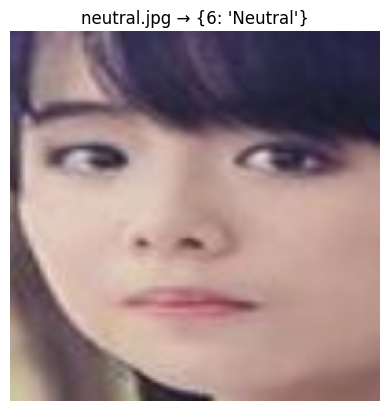

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Ảnh: angry.jpg
→ Output: [[5.5448126e-02 4.6017217e-03 2.4780642e-02 5.1587659e-01 9.3369314e-04
  3.9834687e-01 1.2373789e-05]]
→ Dự đoán: {3: 'Happy'}


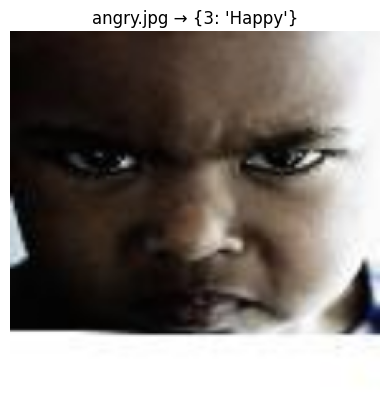

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Ảnh: disgust.jpg
→ Output: [[9.2609470e-12 6.7253030e-05 9.9993277e-01 1.8379247e-10 3.6733588e-16
  6.7713396e-10 6.5134238e-14]]
→ Dự đoán: {2: 'Disgust'}


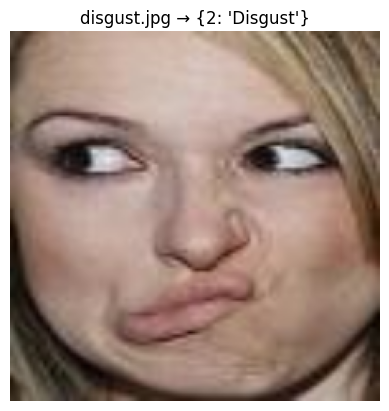

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Ảnh: fear.jpg
→ Output: [[4.8885035e-11 9.9993968e-01 1.2630499e-14 9.0444061e-09 6.0298062e-05
  5.4608943e-13 2.3758437e-09]]
→ Dự đoán: {1: 'Fear'}


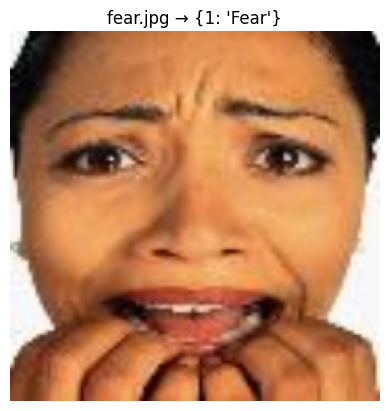

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Ảnh: happy.jpg
→ Output: [[6.0121736e-20 4.2417987e-13 6.5436274e-20 1.0000000e+00 1.3804126e-18
  2.1111635e-13 4.7788085e-20]]
→ Dự đoán: {3: 'Happy'}


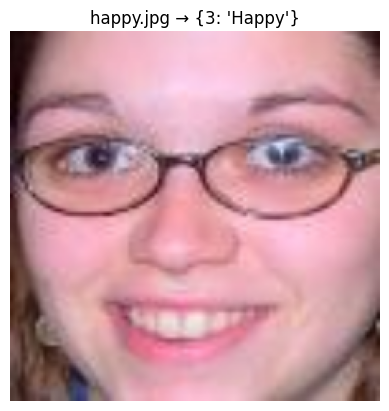

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Ảnh: sad.jpg
→ Output: [[3.9348541e-21 1.4724547e-18 1.3716262e-17 2.3125997e-13 1.0000000e+00
  4.8494841e-12 3.9043991e-20]]
→ Dự đoán: {4: 'Sad'}


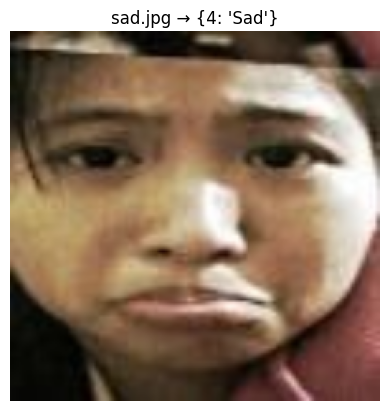

In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def extract_features(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_norm = img.astype('float32') / 255.0
    img_norm = np.expand_dims(img_norm, 0)

    return img, model.predict(img_norm)


test_dir = "/content/test/test"

for file_name in os.listdir(test_dir):
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_dir, file_name)

        img_raw, (feat_l, feat_g, feat_c) = extract_features(feature_model, img_path)

        output = fusion_model.predict([feat_l, feat_g, feat_c])
        pred = classes[np.argmax(output)]


        print("======================================")
        print("Ảnh:", file_name)
        print("→ Output:", output)
        print("→ Dự đoán:", pred)

        plt.imshow(img_raw)
        plt.title(f"{file_name} → {pred}")
        plt.axis("off")
        plt.show()
